# Projet création d'un agent IA Crypto

Ce projet construit un Agent Crypto complet utilisant :

LangGraph

Tools externes : prix, news, reddit

Agents internes : technical, fundamental, sentiment

Fusion layer

Mémoire

Rapport final

Tout tient dans un seul fichier.

## Imports Globaux

In [205]:
import os
import requests
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START


from langchain_community.utilities import GoogleSearchAPIWrapper

from dotenv import load_dotenv
load_dotenv()  
# 🔥 Force absolument la clé OpenAI dans l'environnement
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [206]:
print(os.getenv("OPENAI_API_KEY"))

## State (data structure)

In [207]:
from typing import TypedDict, Optional, List, Dict


class CryptoState(TypedDict, total=False):
    query: str
    intent: str


    price_data: Optional[Dict]
    news_data: Optional[List]
    reddit_data: Optional[List]


    technical_analysis: Optional[str]
    fundamental_analysis: Optional[str]
    sentiment_analysis: Optional[str]


    fusion_output: Optional[str]
    final_report: Optional[str]

    investment_amount: str | None  
    investment_plan: str | None

## Tools

### Price Tool

In [208]:
from langchain.tools import tool
import requests

@tool
def get_crypto_price(asset: str) -> dict:
    """
    Fetch crypto price & market data from the CoinGecko API.
    Returns price, market cap, 24h volatility and supply.
    """
    url = f"https://api.coingecko.com/api/v3/coins/{asset.lower()}"

    try:
        r = requests.get(url, timeout=10)
    except Exception as e:
        return {"error": f"Request failed: {e}"}

    if r.status_code != 200:
        return {"error": f"Crypto not found or API error ({r.status_code})"}

    data = r.json()

    try:
        market = data["market_data"]
        return {
            "name": data.get("name"),
            "symbol": data.get("symbol"),
            "price_usd": market["current_price"].get("usd"),
            "market_cap": market["market_cap"].get("usd"),
            "volatility_24h": market.get("price_change_percentage_24h"),
            "supply": market.get("circulating_supply"),
        }
    except Exception:
        return {"error": "Unexpected API structure"}

### News Tool

In [209]:
import os
from tavily import TavilyClient
from langchain.tools import tool

# Pas besoin d'API key pour le free tier (Tavily autorise l'usage sans clé)
client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))

def tavily_search_raw(query: str, max_results: int = 5) -> dict:
    """
    Effectue une recherche Tavily et retourne du JSON brut.
    Compatible avec toutes les versions de Tavily + LangChain.
    """
    print(f"🔎 Tavily searching: {query} ...")
    return client.search(query=query, max_results=max_results)

def format_tavily_results(results: dict, max_content_chars: int = 2000) -> str:
    """
    Transforme les résultats Tavily en texte propre pour le LLM.
    """
    out = []
    for i, r in enumerate(results.get("results", []), start=1):
        title = r.get("title") or ""
        content = r.get("content") or r.get("raw_content") or ""

        if len(content) > max_content_chars:
            content = content[:max_content_chars] + "…"

        out.append(f"Source {i}:\nTitle: {title}\nContent: {content}\n")

    return "\n".join(out)


In [210]:
@tool
def get_crypto_news(query: str) -> str:
    """
    Search recent news about a crypto asset using Tavily Search,
    then format results into a readable string.
    """
    raw = tavily_search_raw(query + " crypto news", max_results=5)
    formatted = format_tavily_results(raw, max_content_chars=3000)
    return formatted

### Reddit Tool

In [211]:
import praw

# ⚠️ Remets ici TES vraies clés Reddit
reddit = praw.Reddit(
    client_id="LOMZo8eXlm3cpElm1BUAuw",
    client_secret="S_LHRKw9dBHqdBZRjZHfHsRdjlerww",
    user_agent="CryptoAgent/0.1"
)

@tool
def get_reddit_opinions(asset: str) -> list:
    """
    Récupère les top posts Reddit contenant le nom de la crypto.
    """
    posts_data = []

    for post in reddit.subreddit("all").search(f"{asset} crypto", limit=5):
        posts_data.append({
            "title": post.title,
            "score": post.score,
            "comments": post.num_comments,
            "url": post.url
        })

    return posts_data

In [212]:
def ask_investment_amount(state):
    amount = float(input("\n💬 Combien veux-tu investir (€) ? "))
    return {**state, "investment_amount": amount}

def memory_writer(state):
    print("\n🧠 Mémoire enregistrée :", state["investment_plan"])
    return state

In [213]:
def truncate(text, max_chars=1000):
    return text[:max_chars] + "..." if len(text) > max_chars else text

## Agents

### Technical Agent

In [214]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4", temperature=0.4)


def technical_agent(price_data):
    price_data = truncate(price_data, 800)
    prompt = f"""
    Analyse technique simple : tendance, volatilité.

    

    {price_data}
    ⚠️ Ne pas inclure de disclaimers ou avertissements financiers.
    """
    return llm.invoke(prompt).content

### Fundamental Agent

In [215]:
def fundamental_agent(price_data, news_data):
    price_data = truncate(price_data, 800)
    news_data = truncate(news_data, 800)
    prompt = f"""
    Analyse fondamentale : market cap, adoption.


    Price: {price_data}
    News: {news_data}
    ⚠️ Ne pas inclure de disclaimers ou avertissements financiers.
    """
    return llm.invoke(prompt).content

### Sentiment Agent

In [216]:
def sentiment_agent(reddit_data):
    reddit_data = truncate(reddit_data, 800)
    prompt = f"""
    Analyse du sentiment : FUD, FOMO.


    {reddit_data}
    ⚠️ Ne pas inclure de disclaimers ou avertissements financiers.
    """
    return llm.invoke(prompt).content

### Agent d'investissement

In [217]:
def investment_planner(amount: float, report: str):
    prompt = f"""
Basé sur ce rapport crypto:
{report[:1500]}

Montant à investir: {amount}€

Donne une stratégie claire et concise :
- % à allouer (spot, DCA, hold)
- durée recommandée
- justification en 4 lignes max
- aucun disclaimer inutile
pas de disclaimers ou avertissements financiers.
"""
    return llm.invoke(prompt, max_completion_tokens=120).content


## Fusion Master

In [218]:
def fusion_master(technical, fundamental, sentiment):
    prompt = f"""
    Combine les analyses et donne un rating.


    Technical: {technical}
    Fundamental: {fundamental}
    Sentiment: {sentiment}
    """
    return llm.invoke(prompt).content

## Report Generator

In [ ]:
def report_generator(crypto_name, fusion_output, technical, fundamental, sentiment):
    """
    Produit un rapport structuré et lisible basé sur les sorties textuelles
    des agents (fusion, technique, fondamentale, sentiment).
    Tous les paramètres sont de simples chaînes de texte.
    """
    return f"""
    📊 Rapport final pour {crypto_name}

    ---

    ⭐ 1. Score global (Fusion Analysis)

    {fusion_output}

    ---

    📈 2. Analyse Technique

    {technical}

    ---

    🧩 3. Analyse Fondamentale

    {fundamental}

    ---

    😶‍🌫️ 4. Sentiment du Marché
    
    {sentiment}

    ---
    ️⚠️ Ceci est un conseil financier. Faites pas vos propres recherches.
    """


## Memory

In [220]:
MEMORY = {}


def memory_writer(state):
    MEMORY[state["query"]] = state["final_report"]
    return state

## Graph LangGraph

In [221]:
graph = StateGraph(CryptoState)


# Tools
graph.add_node(
    "price",
    lambda s: { "price_data": get_crypto_price.run(s["query"]) }
)

graph.add_node(
    "news",
    lambda s: { "news_data": get_crypto_news.run(s["query"]) }
)

graph.add_node(
    "reddit",
    lambda s: { "reddit_data": get_reddit_opinions.run(s["query"]) }
)

# Analyses
graph.add_node("technical", lambda s: {**s, "technical_analysis": technical_agent(s["price_data"])})
graph.add_node("fundamental", lambda s: {**s, "fundamental_analysis": fundamental_agent(s["price_data"], s["news_data"])})
graph.add_node("sentiment", lambda s: {**s, "sentiment_analysis": sentiment_agent(s["reddit_data"])})

# Fusion
graph.add_node("fusion", lambda s: {**s, "fusion_output": fusion_master(s["technical_analysis"], s["fundamental_analysis"], s["sentiment_analysis"])})

graph.add_node(
    "report",
    lambda s: {
        **s,
        "final_report": report_generator(
            s["query"],
            s["fusion_output"],
            s["technical_analysis"],
            s["fundamental_analysis"],
            s["sentiment_analysis"]
        )
    }
)

# Memory
graph.add_node("memory", memory_writer)

# Edges

# === PHASE DATA ===
# Entry point
graph.set_entry_point("price")

# === PHASE 1 : Collecte de données ===
graph.add_edge(START, "news")
graph.add_edge(START, "price")
graph.add_edge(START, "reddit")

# === PHASE 2 : Analyses ===
graph.add_edge("news", "technical")
graph.add_edge("price", "technical")
graph.add_edge("reddit", "technical")
graph.add_edge("technical", "fundamental")
graph.add_edge("fundamental", "sentiment")

# === PHASE 3 : Fusion ===
graph.add_edge("sentiment", "fusion")

# === PHASE 4 : Rapport (génère final_report) ===
graph.add_edge("fusion", "report")

# === PHASE 5 : Interaction utilisateur ===
graph.add_edge("report", "memory")

# === Fin ===
graph.add_edge("memory", END)

crypto_agent = graph.compile()

## Exécution du programme

## Phase 1

In [222]:
query = input("Crypto à analyser : ")
res = crypto_agent.invoke({"query": query})
print(res["final_report"])

🔎 Tavily searching: bitcoin crypto news ...

    📊 **Rapport final pour bitcoin**

    ---

    ⭐ 1. Score global (Fusion Analysis)

    Rating: Basé sur l'analyse technique, fondamentale et du sentiment, le Bitcoin obtient un rating de 3 sur 5. 

La baisse des prix et la volatilité élevée indiquées par l'analyse technique peuvent être préoccupantes pour certains investisseurs. Cependant, l'analyse fondamentale reste solide avec une capitalisation boursière élevée et une adoption croissante. 

L'analyse du sentiment indique un climat de peur, d'incertitude et de doute, ce qui peut affecter négativement le marché. Cependant, il est important de noter que les sentiments du marché peuvent changer rapidement et ne sont pas toujours un indicateur fiable des performances futures.

En conclusion, bien que le Bitcoin présente actuellement une certaine instabilité, ses fondamentaux solides et son adoption croissante suggèrent un potentiel à long terme. Cependant, les investisseurs doivent faire

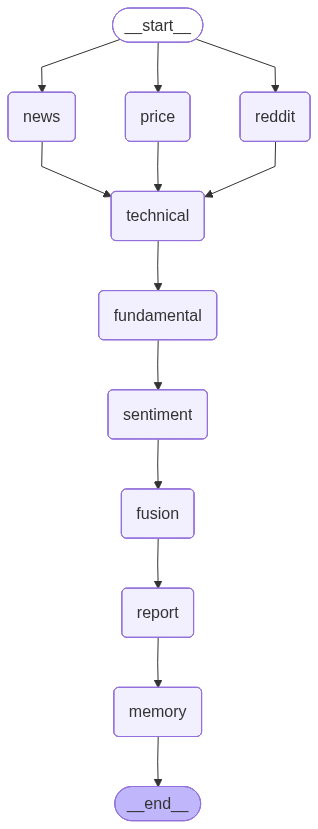

In [223]:
crypto_agent